### Imports

In [1]:
import collections
import glob
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal

### Examine Filenames

In [2]:
data_dir = 'data'
filenames = [os.path.splitext(f)[0] for f in sorted(os.listdir(data_dir))]
fs = 256

We have 17 files, but don't really know what's in them or how much data is in each file

In [3]:
len(filenames)

17

Files are organized by subject_activity.  
Some subjects have two bike datasets  
First 2 subjects have no run  
S3 is the only one that has all 4 classes  
S4 and S5 only have run  
S6 and S8 don't have bike  
S9 only has walk  

In [4]:
filenames 

['s1_bike_0',
 's1_bike_1',
 's1_walk',
 's2_bike_0',
 's2_bike_1',
 's2_walk',
 's3_bike_0',
 's3_bike_1',
 's3_run',
 's3_walk',
 's4_run',
 's5_run',
 's6_run',
 's6_walk',
 's8_run',
 's8_walk',
 's9_walk']

Right away we learn that there is some imbalance in terms of number the representation of each class per subject. This is going to cause some trouble with leave-one-subject-out cross validation.

In [5]:
subjects_per_class = collections.defaultdict(set)
for f in filenames:
    subject = f.split('_')[0]
    activity = f.split('_')[1]
    subjects_per_class[activity].add(subject)

There's also some imbalance in terms of number of subjects per class. For the practicalities of ML, what matters more is imbalance in terms of number of samples per class. If that is unbalanced then our models could be biased towards the class that occurs more often in the training set. Fewer subjects, however, means that we will see less subject-induced variability in the training data.

In [6]:
{k: len(v) for k, v in subjects_per_class.items()}

{'bike': 3, 'walk': 6, 'run': 5}

### Load the data

In [7]:
data = []
for f in filenames:
    subject = f.split('_')[0]
    activity = f.split('_')[1]
    path = os.path.join(data_dir, f + '.csv')
    df = pd.read_csv(path)
    df = df.loc[: df.last_valid_index()]
    data.append((subject, activity, df))

In [9]:
df.head()

,accx,accy,accz
0,3.791152,-9.329793,1.622757
1,3.791152,-9.329285,1.646969
2,3.791366,-9.304383,1.695834
3,3.767274,-9.267029,1.732482
4,3.780279,-9.194481,1.770231


In [10]:
df.shape


(56064, 3)

In [11]:
df.shape[0] / fs / 60

3.65

In [12]:
data

[('s1', 'bike',             accx      accy      accz
  0       2.200615 -2.966250  8.879498
  1       2.163443 -2.990225  8.830109
  2       2.102172 -3.012905  8.828928
  3       2.052951 -3.023489  8.840034
  4       1.991424 -3.058696  8.814513
  5       2.003216 -3.094335  8.850196
  6       2.027571 -3.106214  8.886587
  7       2.076280 -3.119390  8.887060
  8       2.063974 -3.143797  8.850196
  9       2.052182 -3.083319  8.863192
  10      2.040133 -3.058048  8.911872
  11      2.016547 -2.985474  8.900765
  12      1.980656 -2.914411  8.804824
  13      1.993218 -2.888924  8.902183
  14      2.054745 -2.840325  9.000724
  15      2.128321 -2.841621  9.026008
  16      2.262912 -2.856525  9.027663
  17      2.360329 -2.894972  9.028372
  18      2.396989 -2.896052  9.016556
  19      2.384684 -2.920243  8.991744
  20      2.323157 -2.930611  9.002850
  21      2.262655 -2.869701  8.966932
  22      2.250606 -2.858469  8.918488
  23      2.275217 -2.847021  8.918961
  24      2

In [13]:
samples_per_class = collections.defaultdict(int)
for subject, activity, df in data:
    samples_per_class[activity] += len(df)

Plot the number of datapoints per class to get a better idea of the class imbalance.

In [14]:
%matplotlib inline

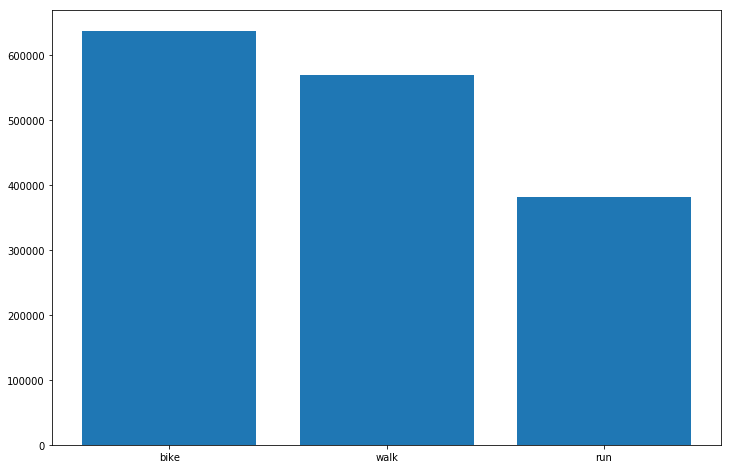

In [15]:
activity, n_samples = list(zip(*samples_per_class.items()))
plt.figure(figsize=(12, 8))
plt.bar(range(3), n_samples)
plt.xticks(range(3), activity);

## Plotting the Raw Data

In [16]:
%matplotlib inline

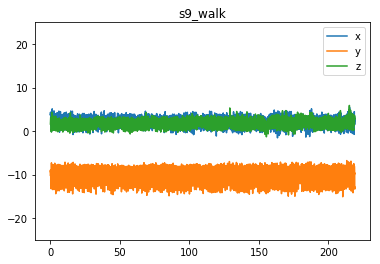

In [20]:
for subject, activity, df in sorted(data, key=lambda x: x[1]):
    ts = np.arange(len(df)) / fs
    plt.clf()
    plt.plot(ts, df.accx, label='x')
    plt.plot(ts, df.accy, label='y')
    plt.plot(ts, df.accz, label='z')
    plt.title('{}_{}'.format(subject, activity))
    plt.legend()
    plt.ylim((-25, 25))
    plt.draw()
#     while not plt.waitforbuttonpress():
#         pass